Reference: 

[XGBOOST-Credit Prediction, by LIM WEI XUAN.](https://www.kaggle.com/code/limweixuan1994/xgboost-credit-prediction/log)

In [1]:
# import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                   
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV

warnings.simplefilter('ignore')

### 训练集数据

In [2]:
path = '/Users/ryan/amex-default-prediction'
df_train = pd.read_feather(os.path.join(path, 'train_data.ftr'))

In [3]:
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

df_train.head(3)

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0


对缺失值处理

In [4]:
def check_null(df):
    null_vals = df.isna().sum().sort_values(ascending=False)
    null_vals[null_vals>0]

    plt.title('Distribution of null values')
    null_vals[null_vals>0].plot(kind='hist')
    
    fig = plt.figure(figsize=(40,10))
    plt.title('Null value counts in columns')
    plt.xlabel('Columns')
    plt.ylabel('Counts')
    null_vals[null_vals>0].plot(kind='bar')

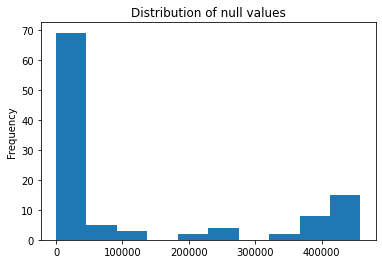

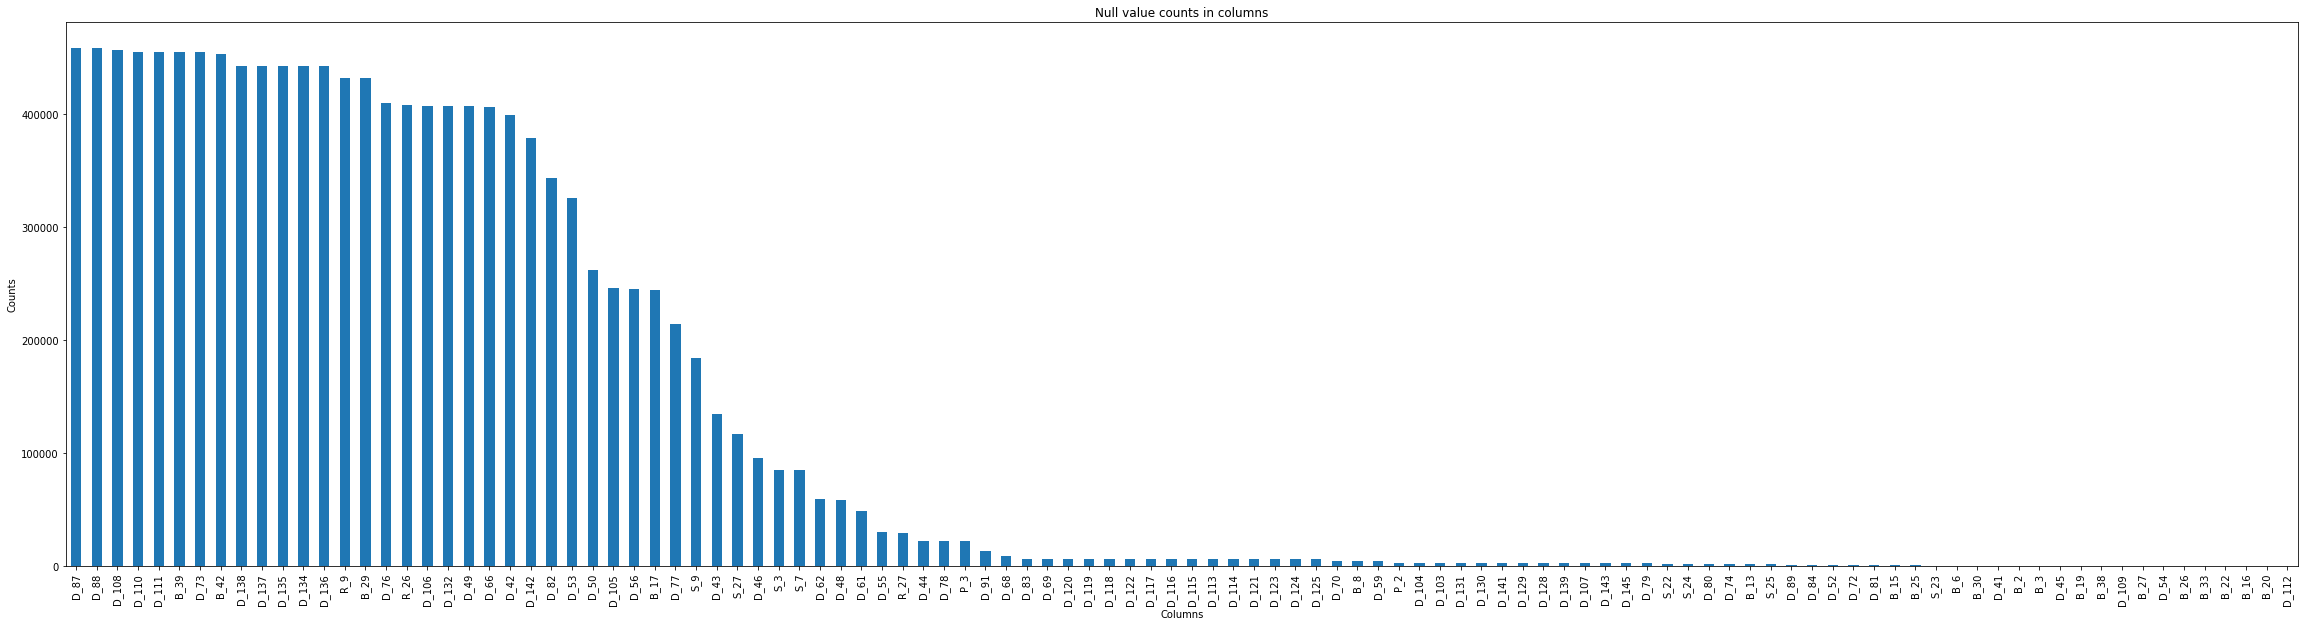

In [5]:
check_null(df_train)

In [6]:
# 在将数据压缩为ftr格式时数据类型可能会有所改变
# 需要转换数据以便后续清洗

for i in df_train.columns:
    if df_train[i].dtypes == np.float16:
        df_train[i] = df_train[i].astype(np.float32)

In [7]:
print('Dataframe shape before cleaning: ', df_train.shape)

print('Dataframe shape after cleaning: ', df_train.dropna(axis=1, thresh=int(0.85*len(df_train))).shape)

# 删除掉缺失值较多的列
df_train.dropna(axis=1, thresh=int(0.85*len(df_train)), inplace=True)
# 对剩余列中的缺失值进行填充
df_train.fillna(method='pad', inplace=True)

df_train.isnull().sum().describe()

Dataframe shape before cleaning:  (458913, 190)
Dataframe shape after cleaning:  (458913, 154)


count    154.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

删除无关变量

In [8]:
df_train.drop(['S_2'], axis=1, inplace=True)

将object数据转化为dummy variable

In [9]:
train_D63 = pd.get_dummies(df_train['D_63'])
df_train = pd.concat([df_train, train_D63], axis=1)
df_train.drop(['D_63'], axis=1, inplace=True)

train_D64 = pd.get_dummies(df_train['D_64'])
df_train = pd.concat([df_train, train_D64], axis=1)
df_train.drop(['D_64'], axis=1, inplace=True)

将categorical数据转化为numerical数据--Label Encoder

In [10]:
from sklearn.preprocessing import LabelEncoder

#! 需要修改：把这个部分做成if判断，是类别变量的可以自动转化为float
# 目前操作：直接将后面报错的数据都转为float64格式

encode_col = ['D_68', 'B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126']
for col in encode_col:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(np.float64))

将上述处理的结果进行归一化

LabelEncoder将类别数据直接转化为0，1，2，3...，但是在整个数据集中，绝大部分数据都分布在[0,1]

In [11]:
for col in encode_col:
    df_train[col] = (df_train[col]-df_train.min())/(df_train.max()-df_train.min())

根据相关性与方差筛选特征 去除掉相关性较高的特征

In [26]:
# 去除掉相关性大于0.85的特征
train_X=df_train.drop(['target'],axis=1)
cor_matrix = train_X.corr().abs()
upper_tri = cor_matrix.where((np.triu(np.ones(cor_matrix.shape), k=1) + np.tril(np.ones(cor_matrix.shape), k=-1)).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

train_X=train_X.drop(to_drop,axis=1)


# 删除掉方差小于0.05的特征
#? 原因

from re import X
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
def fs_variance(df, threshold:float=0.05):
    """
    author: LIM WEI XUAN
    Return a list of selected variables based on the threshold.
    """
    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

columns_to_keep=fs_variance(train_X)
train_final=df_train[columns_to_keep]

train_final1=train_final.join(df_train['target'])
x_train=train_final1.drop(['target'],axis=1)
y_train=train_final1['target']

In [17]:
# 根据测试集数据可知 D_63在测试集有更多的类别
x_train['XL'] = 0
x_train['XM'] = 0
x_train['XZ'] = 0

### 寻参

#### 设置范围进行寻参

In [ ]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.25, random_state=26)

param_random_gb = {'learning_rate': np.arange(0.05, 0.55, 0.1),
                    'n_estimators': [125, 150, 175],
                    'subsample': np.arange(0.3, 1.0, 0.1),
                    'max_depth': [3,4,5]}


# Randomized Search CV
mse_random = RandomizedSearchCV(estimator=XGBClassifier(), 
                                param_distributions=param_random_gb,
                                n_iter=10,
                                scoring='neg_mean_squared_error',
                                cv=4,
                                verbose=1)

mse_random.fit(x_train_split,y_train_split)

# 寻参结果
print('Best parameter: ', mse_random.best_params_)
print('Lower RMSE: ', np.sqrt(np.abs(mse_random.best_score_)))

# 结果如下
# Best parameter:  {'subsample': 0.9000000000000001, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.35000000000000003}
# Lower RMSE:  0.32257527477079256

#### 运用Optuna进行自动寻参

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.25, random_state=26)

# 设置目标函数
def objective(trial,x_train=x_train,y_train=y_train):
    
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.15,random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(x_train_split,y_train_split,eval_set=[(x_test_split,y_test_split)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(x_test_split)
    
    rmse = mean_squared_error(y_test_split, preds,squared=False)
    
    return rmse

# 学习并输出最优参数
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best parameters:', study.best_trial.params)

### XGBoost模型

In [19]:
# 根据最优参数跑训练数据
# model=XGBClassifier(n_estimators=150,max_depth=4,learning_rate=0.35, subsample=0.9)

model = XGBClassifier(n_estimators=160, max_depth=6, learning_rate=0.1, subsample=0.8, booster='dart')
model.fit(x_train_split,y_train_split)
y_predict = model.predict(x_test_split)
print('XGBoost Classifier Accuracy: {:.3f}'.format(accuracy_score(y_test_split, y_predict)))

XGBoost Classifier Accuracy: 0.895


In [20]:
print('\nXGBoost Classifier Precision: {:.3f}'.format(precision_score (y_test_split, y_predict)))


XGBoost Classifier Precision: 0.798


In [21]:
print('\nXGBoost Classifier Recall: {:.3f}'.format(recall_score (y_test_split, y_predict)))


XGBoost Classifier Recall: 0.791


#### 训练集小结

#### 第一次在训练集上预测指标
XGBoost Classifier Accuracy: 0.895

XGBoost Classifier Precision: 0.801

XGBoost Classifier Recall: 0.791

保存用到的特征列表

In [27]:
columns_to_load=list(columns_to_keep)

columns_to_load=columns_to_load+['D_63','D_64','customer_ID','S_2']
remove_list = ['CL', 'CO', 'CR', 'O', 'R', 'U']
for name in remove_list:
    columns_to_load.remove(name)

### 测试集数据

In [28]:
df_test = pd.read_feather(os.path.join(path, 'test_data.ftr'), columns=columns_to_load)
df_test.head(3)

,P_2,D_39,R_1,D_41,B_3,D_44,B_4,D_45,B_5,R_2,...,D_127,D_128,D_129,B_41,D_130,D_131,D_63,D_64,customer_ID,S_2
0,0.631348,0.001912,0.007545,0.009972,0.002348,0.007584,0.116394,0.004482,0.009514,0.005177,...,0.006203,NaN,NaN,0.009666,NaN,NaN,CR,,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19
1,0.586914,0.005276,0.001817,0.000166,0.009132,0.006645,0.134888,0.009499,0.026306,0.009026,...,0.003834,0.008781,0.005577,0.007442,0.007599,0.008072,CR,,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25
2,0.608887,0.003326,0.000114,0.004196,0.004192,0.009605,0.136108,0.007019,0.060028,0.008286,...,0.006760,0.005604,0.009338,0.009598,0.003609,0.009865,CR,,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25


In [29]:
df_test = df_test.groupby('customer_ID').tail(1).set_index('customer_ID')
df_test.drop(['S_2'], axis=1, inplace=True)

test_D63 = pd.get_dummies(df_test['D_63'])
df_test = pd.concat([df_test, test_D63], axis=1)
df_test.drop(['D_63'], axis=1, inplace=True)

test_D64 = pd.get_dummies(df_test['D_64'])
df_test = pd.concat([df_test, test_D64], axis=1)
df_test.drop(['D_64'], axis=1, inplace=True)

In [30]:
columns_to_keep = columns_to_keep + ['XL', 'XM', 'XZ']
df_test = df_test[columns_to_keep]

In [ ]:
for col in encode_col:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col].astype(np.float64))

预测数据

In [32]:
y_test_predict=model.predict_proba(df_test)
y_predict_final=y_test_predict[:,1]

submission = pd.DataFrame({"customer_ID":df_test.index,"prediction":y_predict_final})

提交数据

In [37]:
# 设置索引

submission.set_index('customer_ID', inplace=True)
submission.to_csv('submission_2.csv')